In [127]:
import time

import numpy as np
import numpy.random as npr
import numpy.linalg as npl

# This used to generate a normal pdf (normal.pdf)
from scipy.stats import norm as normal
from scipy.stats import laplace

import seaborn as sns

# Fitting linear models
# import statsmodels.api as sm

import matplotlib.pyplot as plt
# plt.ion()


from scipy.stats import lognorm as lognormal

from tqdm import tqdm

%matplotlib inline


In [361]:
def gd(X, y, t0, iters, lr):
    n, d = X.shape
    thetas = np.zeros((iters, len(t0)))
    thetas[0, :] = t0
    for i in range(1, iters):
        told = thetas[i-1, :]
        thetas[i, :] = told - lr *1./n* X.T.dot(X.dot(told)-y)
        
    return thetas

def err(thetas, tstar):
    iters, d = thetas.shape
    newtstar = np.concatenate((tstar, np.zeros(d-len(tstar))))
    mse = npl.norm(thetas-newtstar, axis=1)**2
    return mse

def train_err(y, X, thetas):
    pred = X.dot(thetas.T)
    error = npl.norm(pred.T-y, axis=1)**2/len(y)
    return error

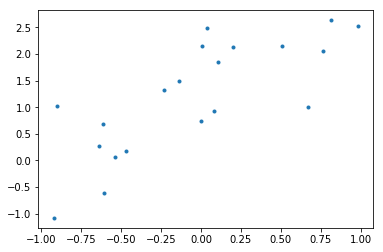

In [590]:
n = 20
x = np.sort(npr.uniform(-1, 1, n))
# x = np.linspace(-0.9, 0.9, n)
X = np.vstack([x, np.ones(len(x))]).T

d = 2
tstar = np.array([1., 1,])
sig = 0.7
eps = sig*npr.randn(n)

ystar = X.dot(tstar)
y = ystar + eps

plt.plot(x, y, '.')
plt.show()

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


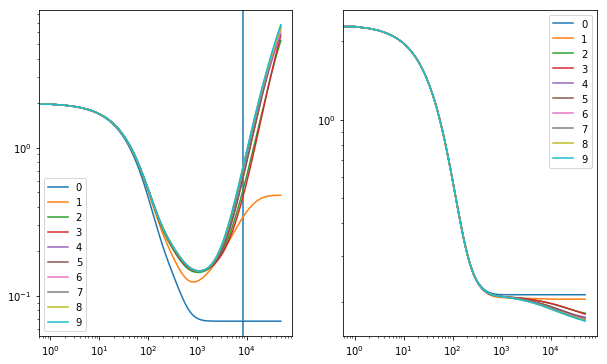

In [582]:
num_models = 10
ntest = 20
xtest = np.linspace(-1, 1, ntest)
Xtest = np.vstack([xtest, np.ones(ntest)]).T
Xtest_full = np.zeros((ntest, num_models+1))
Xtest_full[:,:2] = Xtest
for i in range(2, num_models+1):
    Xtest_full[:, i] = xtest**i/np.sqrt(2*i)

Xfull = np.zeros((n, num_models+1))
Xfull[:,:2] = X
for i in range(2, num_models+1):
    Xfull[:, i] = x**i/np.sqrt(2*i)

lr = .1*np.ones(num_models)
iters = 50000
mse = np.zeros((iters, num_models))
training_err = np.zeros((iters, num_models))
tfinal = list()
ols = list()
ytest_final = np.zeros((ntest, num_models))

plt.figure(figsize=[10, 6])
for i in tqdm(range(0, num_models)):
    t0 = np.zeros(i+2)
    Xfit = Xfull[:, :i+2]
    mylr = 0.2/npl.svd(Xfit, compute_uv=False)[0]**2
    ts = gd(Xfit, y, t0, iters, mylr)
    ytest_final[:, i] = Xtest_full[:, :i+2].dot(ts[-1, :])
    tfinal.append(ts[-1, :])
    ols.append((npl.pinv(Xfit.T.dot(Xfit)).dot(Xfit.T)).dot(y))
    training_err[:, i] = train_err(y, Xfit, ts)
    mse[:, i] = err(ts, tstar)
    plt.subplot(121)
    plt.semilogy(mse[:, i], label=i)
    if i==0:
        plt.axvline(np.argmin(mse[:, 0]))
    
    plt.subplot(122)
    plt.semilogy(training_err[:, i], label=i)
plt.legend()
plt.xscale('log')
plt.subplot(121)
plt.xscale('log')
plt.legend()
plt.show()


In [583]:
for i in range(num_models):
#     print(npl.norm(ols[i]))
    print(npl.norm(tfinal[i]))
    print('')

1.5867770526144498

1.643892806777909

2.9126464250963036

2.9824544168055405

3.0201784176501536

3.113377861945386

3.0643385204916833

3.1380333491395382

3.098618967725918

3.1534225372209246



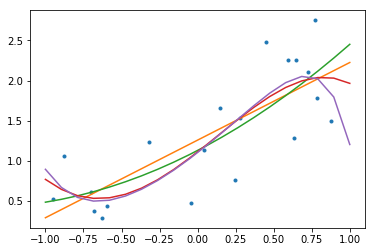

In [584]:
plt.plot(x, y, '.')
plt.plot(xtest, ytest_final[:, 0])
plt.plot(xtest, ytest_final[:, 1])
plt.plot(xtest, ytest_final[:, 3])
plt.plot(xtest, ytest_final[:, 9])
# plt.plot(xtest, ytest_final[:, 19])

# Kernel Regression

In [599]:
def kernel_fun(x,z, degree):
    return (1+x*z)**degree

def kernel_matrix(X, Z, degree):
    n1, n2,  = len(X), len(Z)
    K = np.zeros((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = kernel_fun(X[i], Z[j], degree)
    return K

def kernel_gd(K, y, iters, lr):
    n = len(y)
    ws = np.zeros((iters, n))
    for i in range(1, iters):
        wold = ws[i-1, :]
        ws[i, :] = wold - lr * 1./n * K.dot(K.dot(wold)-y)
    return ws

def kernel_errors(y, ystar, ws, K):
    pred = K.dot(ws.T)
    training_error = npl.norm(pred.T-y, axis=1)**2/len(y)
    mse =  npl.norm(pred.T-ystar, axis=1)**2/len(y)
    return training_error, mse
    
def kernel_fit(degree, wfit, xtrain, xtest):
    Knew = kernel_matrix(xtest, xtrain, degree)
    return(Knew.dot(wfit))

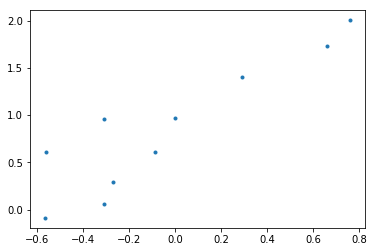

In [646]:
n = 10
x = np.sort(npr.uniform(-1, 1, n))
# x = np.linspace(-0.9, 0.9, n)
X = np.vstack([x, np.ones(len(x))]).T

d = 2
tstar = np.array([1., 1,])
sig = 0.5
eps = sig*npr.randn(n)

ystar = X.dot(tstar)
y = ystar+eps

plt.plot(x, y, '.')
plt.show()

5it [00:00,  6.48it/s]


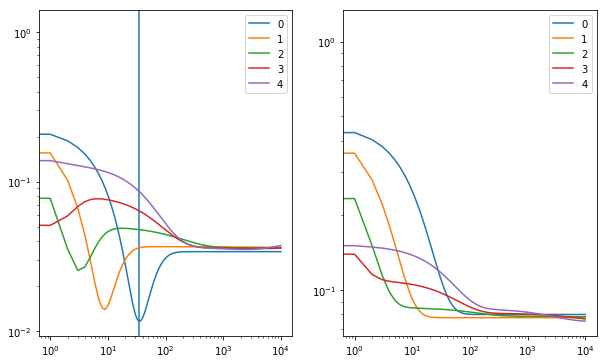

In [649]:
num_models = 5
ntest = 20
xtest = np.linspace(-1, 1, ntest)

lr = .1*np.ones(num_models)

iters = 10000
k_mse = np.zeros((iters, num_models))
k_training_err = np.zeros((iters, num_models))
k_ytest_final = np.zeros((ntest, num_models))


plt.figure(figsize=[10, 6])
for i, degree in tqdm(enumerate(range(1, num_models+1))):
    K = kernel_matrix(x, x, degree)
    mylr = n/npl.svd(K, compute_uv=False)[0]**2
    ws = kernel_gd(K=K, iters=iters,lr=mylr,y=y)
    
    k_ytest_final[:, i] = kernel_fit(degree=degree,wfit=ws[-1, :],xtest=xtest,xtrain=x)
    k_training_err[:, i], k_mse[:, i] = kernel_errors(y, ystar, ws, K)

    plt.subplot(121)
    plt.semilogy(k_mse[:, i], label=i)
    if i==0:
        plt.axvline(np.argmin(k_mse[:, 0]))
    
    plt.subplot(122)
    plt.semilogy(k_training_err[:, i], label=i)
plt.legend()
plt.xscale('log')
plt.subplot(121)
plt.xscale('log')
plt.legend()
plt.show()



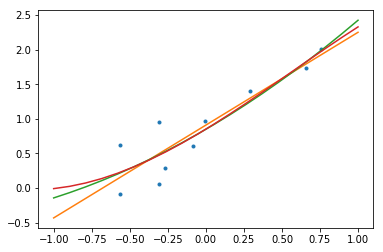

In [650]:
plt.plot(x, y, '.')
plt.plot(xtest, k_ytest_final[:, 0])
plt.plot(xtest, k_ytest_final[:, 1])
plt.plot(xtest, k_ytest_final[:, 3])
# plt.plot(xtest, k_ytest_final[:, 9])
# plt.plot(xtest, ytest_final[:, 19])

## Linear Regression n and d

In [12]:
def gen_data(n, d, snr=1, s=None, f=None):
    # n samples in d dimensions, 
    # norm of beta is snr and s denotes the sparsity

    if s==None:
        s=d
    x = npr.randn(n, d)
    beta = np.zeros(d)
    beta[:s] = npr.randn(s)
    beta[:s] /= npl.norm(beta[:s])
    beta[:s] *= snr
    
    eps = npr.randn(n)
    if f is None:
        y = x.dot(beta) + eps

    return(beta, x, y)

def ols(x, y):
    betahat = npl.pinv(x.T @ x) @ (x.T @ y)
    return(betahat)

def ols_mse(xtest, betastar, betahat):
    return(npl.norm(betastar-betahat)**2, npl.norm(xtest.dot(betastar-betahat))**2/xtest.shape[0])


In [ ]:
params = dict()
params['snr'] = [1, 5]
params['ns'] = 10*np.power(2, np.arange(0, 10))

In [434]:
def error_plots(n, d, snr, s, numplots):
    plt.figure(figsize=[12, 3])
    for i in tqdm(range(numplots)):
        plt.subplot(1, numplots, i+1)
        betastar, xtrain, ytrain = gen_data(n, d, s)
        betahat = ols(xtrain, ytrain)

        v = np.ones(d)
        v /= npl.norm(v)
        S = np.eye(d) + (np.sqrt(10)-1)* np.outer(v, v)

        S2 = np.cumsum(np.ones(d))
        S2 /= np.sum(S2)
        S2 = np.diag(np.sqrt(S2*d))
        keys = ['gauss', 'gauss_shifted', 'gauss_spike', 'gauss_scale', 'unif', 'unif_shifted', 'lap']

        numtrials = 2000

        ntest = 500

        avg_err = dict()
        std_err = dict()
        for key in keys:
            avg_err[key] = np.zeros(numtrials)
            std_err[key] = np.zeros(numtrials)
        xtest = dict()
        gauss_shift = np.ones(d)
        unif_shift = npr.rand(d)
        for t in range(numtrials):
            errors = dict()
            xtest['gauss'] = (npr.randn(ntest, d) ) / np.sqrt(ntest)
            xtest['gauss_shifted'] = (npr.randn(ntest, d) + gauss_shift) / np.sqrt(ntest)
            xtest['gauss_spike'] = npr.randn(ntest, d) @ S  / np.sqrt(ntest)
            xtest['gauss_scale'] = npr.randn(ntest, d) @ S2  / np.sqrt(ntest)
        #     xtest['unif'] = (npr.rand(ntest, d))  / np.sqrt(ntest)
        #     xtest['unif_shifted'] = (npr.rand(ntest, d)+unif_shift)  / np.sqrt(ntest)
            xtest['lap'] = npr.laplace(size=(ntest, d))  / np.sqrt(ntest)
            for i, (key, value) in enumerate(xtest.items()):
                errors[key] = (value @(betastar-betahat))**2
                avg_err[key][t], std_err[key][t] = np.mean(errors[key]), np.std(errors[key])



        for i, key in enumerate(xtest.keys()):
            sns.distplot(avg_err[key]+std_err[key], label=key)
    plt.suptitle(r'snr=%.1f,  ntrain=%d, d=%d, ntest=%d, trials=%d'%(snr, n, d, ntest, numtrials))
    plt.legend()
    plt.show()



100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


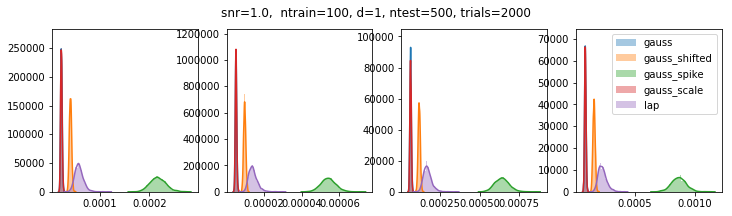

100%|██████████| 4/4 [00:12<00:00,  3.13s/it]


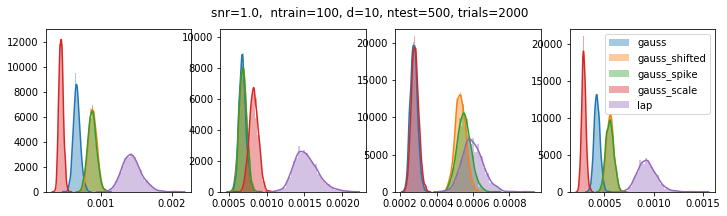

100%|██████████| 4/4 [01:33<00:00, 23.26s/it]


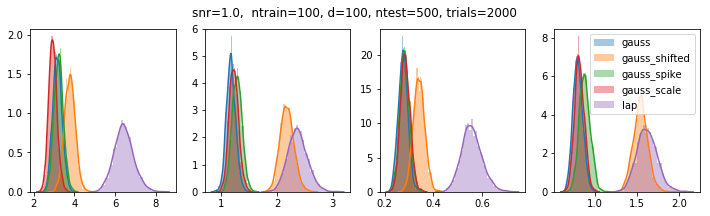

100%|██████████| 4/4 [24:05<00:00, 361.34s/it]


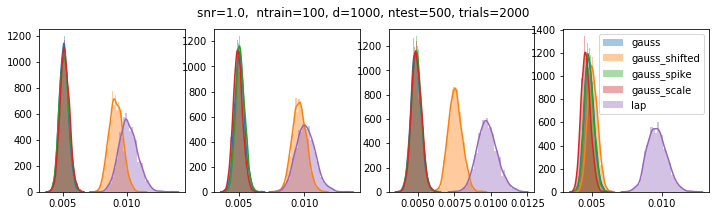

In [437]:
numplots = 4
snr, s = 1, 1

n, d = 100, 1
error_plots(n, d, snr, s, numplots)

n, d = 100, 10
error_plots(n, d, snr, s, numplots)

n, d = 100, 100
error_plots(n, d, snr, s, numplots)

n, d = 100, 1000
error_plots(n, d, snr, s, numplots)


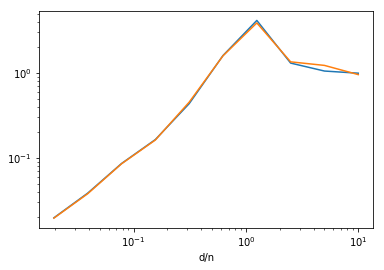

In [8]:
ns = 10*np.power(2, np.arange(0, 10))
d = 100
ntrials = 10
beta_evals = np.zeros((len(ns), ntrials))
y_evals = np.zeros((len(ns), ntrials))
for t in range(ntrials):
    for i, n in enumerate(ns):
        beta, x, y = gen_data(n, d)
        betahat = ols(x, y)
        beta_evals[i, t], y_evals[i, t] = ols_mse(npr.randn(n, d), beta, betahat)
plt.loglog(d/ns, np.mean(beta_evals, axis=1))
plt.loglog(d/ns, np.mean(y_evals, axis=1))
plt.xlabel('d/n')
plt.show()

In [749]:
n = 200
ds = np.power(2, np.arange(0, 11)) 
ntrials = 10
beta_evals = np.zeros((len(ds), ntrials))
y_evals = np.zeros((len(ds), ntrials))
for t in tqdm(range(ntrials)):
    for i, d in enumerate(ds):
        beta, x, y = gen_data(n, d)
        betahat = ols(x, y)
        beta_evals[i, t], y_evals[i, t] = ols_mse(x, beta, betahat)



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:07,  1.16it/s]

 20%|██        | 2/10 [00:01<00:06,  1.17it/s]

 30%|███       | 3/10 [00:02<00:05,  1.18it/s]

 40%|████      | 4/10 [00:03<00:05,  1.18it/s]

 50%|█████     | 5/10 [00:04<00:04,  1.18it/s]

 60%|██████    | 6/10 [00:05<00:03,  1.18it/s]

 70%|███████   | 7/10 [00:05<00:02,  1.18it/s]

 80%|████████  | 8/10 [00:06<00:01,  1.19it/s]

 90%|█████████ | 9/10 [00:07<00:00,  1.19it/s]

100%|██████████| 10/10 [00:08<00:00,  1.19it/s]

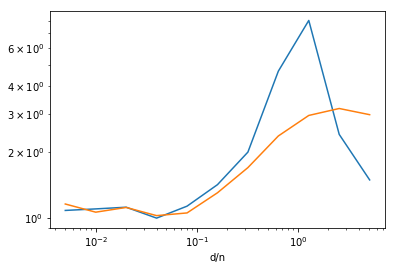

In [750]:
plt.loglog(ds/n, np.mean(beta_evals, axis=1))
plt.loglog(ds/n, np.mean(y_evals, axis=1))
plt.xlabel('d/n')
plt.show()

In [4]:
## 
d= 50
n = 100
A = npr.randn(d, d)/np.sqrt(d)
X = npr.randn(n, d)/np.sqrt(n)
wstar = np.ones(d)/np.sqrt(d)
noise = npr.randn(n)
y = X.dot(wstar) + 2*noise/np.sqrt(n)

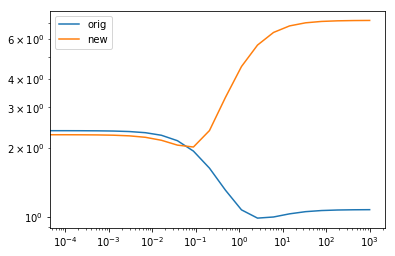

In [6]:
xtx = X.T.dot(X)

wols = npl.pinv(xtx).dot(X.T.dot(y))

trials = 10

lambs = np.concatenate(([0], np.power(10., np.linspace(-4, 3, 20))))
mse = np.zeros((len(lambs), trials))
msea = np.zeros((len(lambs), trials))
for t in range(trials):
    Xnew = npr.randn(n, d)/np.sqrt(n)
    Xnewa = npr.rand(n, d)/np.sqrt(n)
#     Xnewa = npr.laplace(size=(n, d))/np.sqrt(n)
    Xnewa = (npr.randn(n, d)+1.)/np.sqrt(n)
    for i, lamb in enumerate(lambs):
        wridge = npl.pinv(xtx+lamb*np.eye(d)).dot(X.T.dot(y))
        mse[i, t] = npl.norm(Xnew.dot(wridge-wstar))
        msea[i, t] = npl.norm(Xnewa.dot(wridge-wstar))
plt.loglog(lambs, np.mean(mse, axis=1)+np.std(mse, axis=1), label='orig')
plt.loglog(lambs,  np.mean(msea, axis=1)+np.std(msea, axis=1), label='new')
plt.legend()
plt.show()